# Afro-MNIST with SciKit-Learn and skorch

In [1]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [3]:
!gdown 1GwzlZh15WOwEPcadkn0DHRbiQH9FuQzr

Downloading...
From (original): https://drive.google.com/uc?id=1GwzlZh15WOwEPcadkn0DHRbiQH9FuQzr
From (redirected): https://drive.google.com/uc?id=1GwzlZh15WOwEPcadkn0DHRbiQH9FuQzr&confirm=t&uuid=706f2f24-7fc0-47b8-a581-a1431016f6da
To: /content/Afro-MNIST.zip
100% 108M/108M [00:04<00:00, 23.7MB/s]


In [4]:
!unzip Afro-MNIST.zip

Archive:  Afro-MNIST.zip
  inflating: Ethiopic/Ethiopic_MNIST_X_test.npy  
  inflating: Ethiopic/Ethiopic_MNIST_X_train.npy  
  inflating: Ethiopic/Ethiopic_MNIST_y_test.npy  
  inflating: Ethiopic/Ethiopic_MNIST_y_train.npy  
  inflating: NKo/NKo_MNIST_X_test.npy  
  inflating: NKo/NKo_MNIST_X_train.npy  
  inflating: NKo/NKo_MNIST_y_test.npy  
  inflating: NKo/NKo_MNIST_y_train.npy  
  inflating: Osmanya/Osmanya_MNIST_X_test.npy  
  inflating: Osmanya/Osmanya_MNIST_X_train.npy  
  inflating: Osmanya/Osmanya_MNIST_y_test.npy  
  inflating: Osmanya/Osmanya_MNIST_y_train.npy  
  inflating: Vai/Vai_MNIST_X_test.npy  
  inflating: Vai/Vai_MNIST_X_train.npy  
  inflating: Vai/Vai_MNIST_y_test.npy  
  inflating: Vai/Vai_MNIST_y_train.npy  


In [5]:
cd Ethiopic

/content/Ethiopic


In [6]:
X_train = np.load("Ethiopic_MNIST_X_train.npy")
y_train = np.load("Ethiopic_MNIST_y_train.npy").astype('int64')
X_test  = np.load("Ethiopic_MNIST_X_test.npy")
y_test  = np.load("Ethiopic_MNIST_y_test.npy").astype('int64')
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [8]:
X_train = X_train.reshape((X_train.shape[0], 28*28))
X_test = X_test.reshape((X_test.shape[0], 28*28))

### Print a selection of training images and their labels

In [9]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

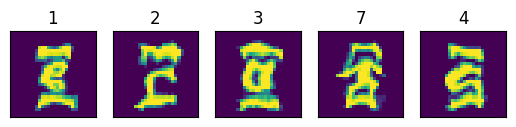

In [10]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch

In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
mnist_dim = 28 * 28
hidden_dims = [int(mnist_dim/8)]
output_dim = 10

In [14]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dims=hidden_dims,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
              self.hidden.append(nn.Linear(mnist_dim, hidden_dims[i]))
            else:
              self.hidden.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
        self.output = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, X, eval=False, **kwargs):
        Ts = None
        layers = None
        layer_num = 0
        for h in self.hidden:
          X = F.relu(h(X))
          if eval:
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
          layer_num += 1
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        if eval:
          return X, Ts, layers
        return X

In [15]:
from skorch import NeuralNetClassifier
nets = []

In [16]:
torch.manual_seed(0)

net1 = NeuralNetClassifier(
    ClassifierModule(mnist_dim, [100], output_dim),
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [18]:
net1.fit(X_train, y_train)
nets.append(net1)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5622       0.9805        0.0971  1.7024
      2        0.1370       0.9868        0.0537  1.0827
      3        0.0962       0.9884        0.0403  1.0516
      4        0.0801       0.9897        0.0341  1.0927
      5        0.0705       0.9905        0.0313  1.0184
      6        0.0635       0.9904        0.0286  1.0681
      7        0.0578       0.9895        0.0292  1.3725
      8        0.0521       0.9908        0.0260  1.3311
      9        0.0507       0.9916        0.0250  1.0328
     10        0.0479       0.9908        0.0259  1.0334
     11        0.0453       0.9918        0.0227  1.0410
     12        0.0452       0.9922        0.0229  1.0330
     13        0.0418       0.9926        0.0223  1.0666
     14        0.0404       0.9926        0.0217  1.0348
     15        0.0399       0.9923        0.0204  1.0746
     16        0.0379       0.9

In [19]:
y_pred = net1.predict(X_test)
accuracy_score(y_test, y_pred)

0.9923

In [20]:
hidden_dims = [60, 40]
net2 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net2.fit(X_train, y_train);
nets.append(net2)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9101       0.9682        0.1292  1.1436
      2        0.2279       0.9806        0.0623  1.0904
      3        0.1562       0.9870        0.0402  1.1562
      4        0.1262       0.9891        0.0328  1.1003
      5        0.1074       0.9889        0.0301  1.1062
      6        0.0997       0.9902        0.0270  1.2418
      7        0.0936       0.9900        0.0279  1.5152
      8        0.0858       0.9908        0.0249  1.6988
      9        0.0793       0.9902        0.0254  1.5071
     10        0.0748       0.9902        0.0248  1.1055
     11        0.0691       0.9913        0.0232  1.1085
     12        0.0646       0.9922        0.0207  1.0974
     13        0.0637       0.9914        0.0217  1.1079
     14        0.0635       0.9909        0.0231  1.0952
     15        0.0573       0.9920        0.0210  1.0884
     16        0.0561       0.9

In [21]:
y_pred = net2.predict(X_test)
accuracy_score(y_test, y_pred)

0.9934

In [22]:
hidden_dims = [40, 60]
net3 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net3.fit(X_train, y_train);
nets.append(net3)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6982       0.9741        0.0923  1.1247
      2        0.1511       0.9831        0.0534  1.0996
      3        0.1114       0.9858        0.0421  1.0862
      4        0.0896       0.9873        0.0372  1.1140
      5        0.0779       0.9889        0.0324  1.0727
      6        0.0694       0.9887        0.0333  1.1517
      7        0.0630       0.9893        0.0294  1.1350
      8        0.0589       0.9906        0.0259  1.1236
      9        0.0552       0.9911        0.0254  1.2700
     10        0.0509       0.9909        0.0244  1.5122
     11        0.0496       0.9913        0.0235  1.2665
     12        0.0461       0.9909        0.0246  1.1216
     13        0.0433       0.9921        0.0208  1.0955
     14        0.0427       0.9924        0.0212  1.0623
     15        0.0376       0.9927        0.0203  1.0867
     16        0.0378       0.9

In [23]:
y_pred = net3.predict(X_test)
accuracy_score(y_test, y_pred)

0.9934

In [24]:
error_mask = y_pred != y_test

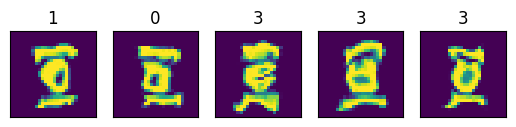

In [25]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [27]:
hidden_dims = [50, 50]
net4 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net4.fit(X_train, y_train);
nets.append(net4)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8214       0.9703        0.1020  1.3852
      2        0.1830       0.9807        0.0554  1.0888
      3        0.1258       0.9849        0.0417  1.0833
      4        0.0997       0.9869        0.0359  1.1238
      5        0.0879       0.9876        0.0340  1.1279
      6        0.0807       0.9890        0.0296  1.1479
      7        0.0716       0.9896        0.0291  1.5167
      8        0.0682       0.9893        0.0290  1.1125
      9        0.0651       0.9884        0.0308  1.1546
     10        0.0607       0.9911        0.0247  1.4553
     11        0.0593       0.9912        0.0251  1.5057
     12        0.0554       0.9914        0.0239  1.1479
     13        0.0535       0.9910        0.0246  1.1122
     14        0.0516       0.9912        0.0239  1.0941
     15        0.0492       0.9916        0.0233  1.0891
     16        0.0467       0.9

In [28]:
y_pred = net4.predict(X_test)
accuracy_score(y_test, y_pred)

0.9923

In [29]:
hidden_dims = [20, 20, 20, 20, 20]
net5 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net5.fit(X_train, y_train);
nets.append(net5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3023       0.1102        2.2968  1.7698
      2        2.0699       0.2836        1.5386  1.3953
      3        1.3983       0.5862        0.9490  1.3365
      4        0.9865       0.8182        0.5206  1.2803
      5        0.7029       0.8345        0.4168  1.2993
      6        0.5546       0.9056        0.3187  1.2538
      7        0.6015       0.9274        0.3018  1.2921
      8        0.4972       0.9347        0.2762  1.2810
      9        0.5802       0.9166        0.3235  1.3735
     10        0.4720       0.9306        0.2702  1.7205
     11        0.4501       0.9409        0.2436  1.4420
     12        0.6189       0.9187        0.2975  1.3205
     13        0.4493       0.9307        0.2589  1.2691
     14        0.4577       0.9340        0.2508  1.3580
     15        0.4316       0.9091        0.2935  1.3530
     16        0.4077       0.9

In [30]:
y_pred = net5.predict(X_test)
accuracy_score(y_test, y_pred)

0.9496

In [31]:
def get_correlation(module1, module2, X):
  Ts1, layers1 = module1.forward(X, eval=True)[1], module1.forward(X, eval=True)[2]
  Ts2, layers2 = module2.forward(X, eval=True)[1], module2.forward(X, eval=True)[2]

  correlations = np.zeros_like(Ts1.cpu().detach().numpy()[0])
  for i in range(Ts1.shape[1]):
    neuron_i = Ts1[:, i]
    max_idx = 0
    max_corr = -1
    for j in range(Ts2.shape[1]):
      neuron_j = Ts2[:, j]
      stacked = torch.stack((neuron_i, neuron_j))
      corr = torch.corrcoef(stacked)[0, 1] / (abs(layers1[0, i] - layers2[0, j]) + 1)
      corr = np.abs(corr.cpu().detach().numpy())
      if np.isnan(corr):
        corr = 0
      if corr > max_corr:
        max_corr = corr
        max_idx = j
    correlations[i] = max_corr

  return correlations.mean()

def mean_correlation(module1, module2, X):
    return (get_correlation(module1, module2, X) + get_correlation(module2, module1, X)) / 2

In [32]:
for i in range(len(nets)):
  for j in range(i + 1, len(nets)):
    correlation = get_correlation(nets[i].module, nets[j].module, torch.tensor(X_test).to(device))
    print("correlation between net" + str(i + 1) + " and net" + str(j + 1) + ":", correlation)

correlation between net1 and net2: 0.6208968
correlation between net1 and net3: 0.61332965
correlation between net1 and net4: 0.62839466
correlation between net1 and net5: 0.46474802
correlation between net2 and net3: 0.70023024
correlation between net2 and net4: 0.7124784
correlation between net2 and net5: 0.55144495
correlation between net3 and net4: 0.7359658
correlation between net3 and net5: 0.5564774
correlation between net4 and net5: 0.54682314


# Convolutional Network


In [37]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [38]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn(),
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [39]:
cnn.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3409       0.9978        0.0069  2.8060
      2        0.0348       0.9992        0.0027  1.6763
      3        0.0230       0.9992        0.0023  1.6495
      4        0.0168       0.9997        0.0007  2.3960
      5        0.0150       0.9998        0.0006  1.6405
      6        0.0130       0.9998        0.0008  1.7632
      7        0.0109       0.9998        0.0004  2.1031
      8        0.0107       0.9999        0.0004  1.6514
      9        0.0100       0.9998        0.0005  1.6391
     10        0.0103       0.9995        0.0010  1.6376


In [40]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9993

In [42]:
for i in range(len(nets)):
  correlation = get_correlation(nets[i].module, cnn.module, torch.tensor(X_test[:10]).to(device))
  print("correlation between net" + str(i + 1) + " and cnn:", correlation)

correlation between net1 and cnn: 0.776968
correlation between net2 and cnn: 0.7943495
correlation between net3 and cnn: 0.83942634
correlation between net4 and cnn: 0.8396347
correlation between net5 and cnn: 0.34819618
